# Name: Luke Pratley

# Testing EfficientNet UNet

In [1]:
#!pip install keras==2.8
#!pip install tensorflow-gpu==2.8
%load_ext nb_black

import tensorflow as tf
print(tf.__version__)
import tensorflow.keras 
import tensorflow.keras.applications.efficientnet

import tensorboard

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import math

import sys
import glob
import os

from sklearn.model_selection import train_test_split

sys.path.append('..')

import building_road_segmentation.unet_factory as unet_factory
import building_road_segmentation.optimization_factory as optimization_factory
import building_road_segmentation.data_generator as data_generator
import building_road_segmentation.loss_functions as loss_functions

2.8.0


<IPython.core.display.Javascript object>

In [2]:
image_dir =  glob.glob("..\\data_cleaning_EDA\\final_images_small\\*")
mask_dir =  glob.glob("..\\data_cleaning_EDA\\final_masks_small\\*")
for p in range(len(image_dir)):
    s1 = image_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.png', '')
    s2 = mask_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.npy', '')
    assert s1 == s2

<IPython.core.display.Javascript object>

In [3]:
train_image_dir, test_image_dir, train_mask_dir, test_mask_dir = train_test_split(image_dir, mask_dir, test_size=0.3, random_state=42)

<IPython.core.display.Javascript object>

In [4]:
train_data = data_generator.READ_AND_AUGMENT_DATA(train_image_dir, train_mask_dir, batch_size=64)
test_data = data_generator.READ_DATA(test_image_dir, test_mask_dir, batch_size=128)

<IPython.core.display.Javascript object>

In [14]:
losses = {'dice_loss' : loss_functions.weighted_dice_loss([1, 1]), 'BinaryCrossentropy': tf.keras.losses.BinaryCrossentropy()}

<IPython.core.display.Javascript object>

In [15]:
model_configurations = {'efficient_model_1': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'},
                        'efficient_model_2': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'},
                        'efficient_res_model_1': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'dice_loss'},
                        'efficient_res_model_2': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'BinaryCrossentropy'},
                       }
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

<IPython.core.display.Javascript object>

In [7]:
for model_name, model_config in model_configurations.items():
    print(model_name, model_config)
    if not os.path.exists(model_name):
        unet_model = unet_factory.EfficientNetUNet(efficientnet=tensorflow.keras.applications.efficientnet.EfficientNetB4,
                                            number_of_categories=2,
                                            unet_levels=model_config['unet_levels'],
                                            number_of_start_kernels=model_config['number_of_start_kernels'],
                                            kernel_shape=(3, 3),
                                            activation='relu',
                                            final_activation='sigmoid',
                                            pooling_amount=model_config['pooling_amount'],
                                            dropout_rate=0.2, residual=model_config['residual'])

        modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True)
        unet_model.compile(optimizer=optimizer, loss=losses[model_config['loss']], metrics=['accuracy'])
        history = unet_model.fit(train_data, epochs=100, validation_data=test_data, callbacks=[modelcheckpoint])
        history = pd.DataFrame(history.history) 
        history.to_csv(f'{model_name}_history.csv')  

efficient_model_1 {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice'}
Epoch 1/100
262/262 [==============================] - 157s 572ms/step - loss: 0.3930 - accuracy: 0.8204 - val_loss: 0.3315 - val_accuracy: 0.8745
Epoch 2/100
262/262 [==============================] - 145s 554ms/step - loss: 0.2766 - accuracy: 0.8724 - val_loss: 0.2759 - val_accuracy: 0.8890
Epoch 3/100
262/262 [==============================] - 144s 548ms/step - loss: 0.2521 - accuracy: 0.8803 - val_loss: 0.2618 - val_accuracy: 0.8924
Epoch 4/100
262/262 [==============================] - 147s 558ms/step - loss: 0.2386 - accuracy: 0.8829 - val_loss: 0.2556 - val_accuracy: 0.8842
Epoch 5/100
262/262 [==============================] - 149s 566ms/step - loss: 0.2286 - accuracy: 0.8820 - val_loss: 0.2538 - val_accuracy: 0.8870
Epoch 6/100
262/262 [==============================] - 148s 565ms/step - loss: 0.2215 - accuracy: 0.8783 - val_loss: 0.2524 - val_accuracy: 0

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[64,128,128,2] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_22/Sigmoid-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_62930270]

<IPython.core.display.Javascript object>

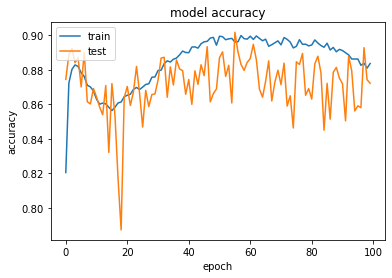

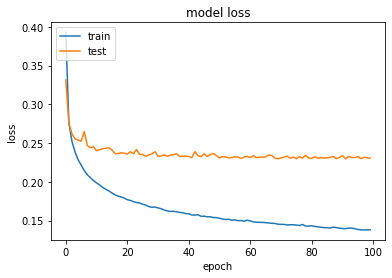

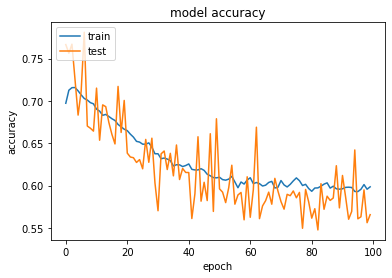

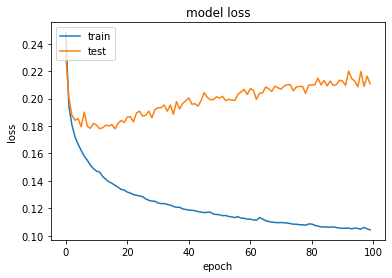

<IPython.core.display.Javascript object>

In [8]:

histories = []
for model_name, model_config in model_configurations.items():
    if os.path.exists(model_name):
        histories.append(pd.read_csv(model_name +'_history.csv'))
    # summarize history for accuracy
for history in histories:
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:
X_test = np.array([np.array(PIL.Image.open(im)).astype(float) for im in test_image_dir])

<IPython.core.display.Javascript object>

In [24]:
y_test = np.array([
            np.load(file_name)
               for file_name in test_mask_dir])

<IPython.core.display.Javascript object>

In [27]:
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)
for k, (model_name, model_config) in enumerate(model_configurations.items()):
    if os.path.exists(model_name):
        final_model = tf.keras.models.load_model(model_name, custom_objects={model_config['loss']: losses[model_config['loss']]})
        print(model_config)
        y_pred = final_model.predict(X_test/255)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        print(np.mean([loss_functions.intersection_over_union(y_test[k, :, :, 0], y_pred[k, :, :, 0]) for k in range(y_test.shape[0])]))
        print(np.mean([loss_functions.intersection_over_union(y_test[k, :, :, 1], y_pred[k, :, :, 1]) for k in range(y_test.shape[0])]))
        print(classification_report(y_pred, y_test))

{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}
0.5869303345254389
0.6596177029266977
{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'}
0.5788682651489875
0.6536472750411093


<IPython.core.display.Javascript object>

In [28]:
def plot_result(X_test, y_test, model_name, display_prob, index=0):
    if os.path.exists(model_name):
        final_model = tf.keras.models.load_model(model_name, custom_objects={model_config['loss']: losses[model_config['loss']]})
        y_pred = final_model.predict(X_test)
        if not display_prob:
            y_pred = np.where(y_pred > 0.5, 1, 0)
        fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)
        ax[0, 0].imshow((X_test[index] * 255).astype(int), vmin=0, vmax=255)
        ax[1, 0].imshow(y_test[index, :, :, 0] * 0.5 + y_test[index, :, :, 1] * 0.25, vmin = 0)
        ax[1, 1].imshow(y_test[index, :, :, 0], vmin = 0, vmax=1)
        ax[1, 2].imshow(y_test[index, :, :, 1], vmin = 0, vmax=1)
        ax[0, 1].imshow(y_pred[index, :, :, 0], vmin = 0, vmax=1)
        ax[0, 2].imshow(y_pred[index, :, :, 1], vmin = 0, vmax=1)

<IPython.core.display.Javascript object>

{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}


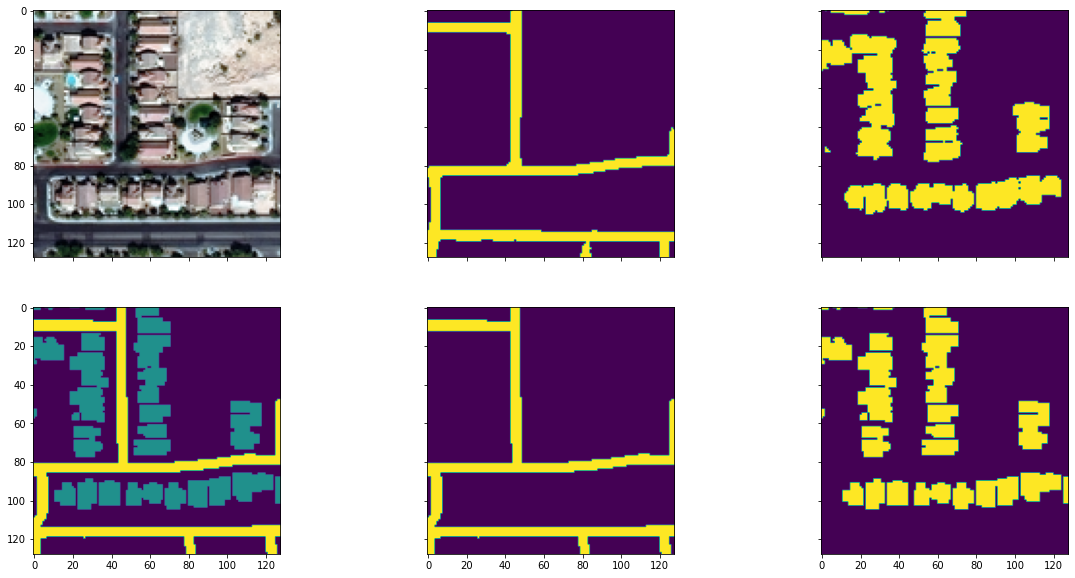

{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'}


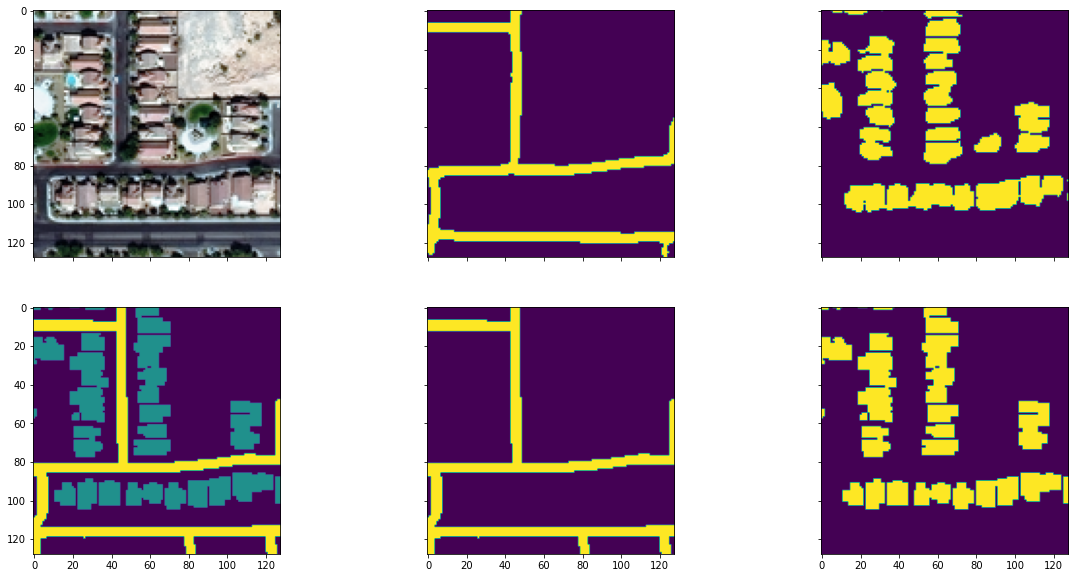

{'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}
{'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'}
{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'dice_loss'}
{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'BinaryCrossentropy'}
{'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'dice_loss'}
{'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'BinaryCrossentropy'}


<IPython.core.display.Javascript object>

In [34]:
k = 500
for model_name, model_config in model_configurations.items():
    print(model_config)
    batch = math.ceil(k / test_data.batch_size)
    X_test, y_test = test_data.__getitem__(batch)
    plot_result(X_test, y_test, model_name=model_name, display_prob=False, index=k - batch * test_data.batch_size)
    plt.show()